In [1]:
from datetime import datetime
from time import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='Spectral')

In [2]:
movies = pd.read_csv("../datasets/ml-latest/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [4]:
movies.shape

(86537, 3)

In [5]:
print(movies.movieId.nunique(), movies.title.nunique())

86537 86330


### Drop duplicated movies

In [6]:
movies = movies[~movies.title.duplicated('last')].copy()
movies = movies.reset_index(drop=True)
movies.shape

(86330, 3)

### Check for null values

In [7]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

### Genres are listed with a seperator. Split and list individual genres for individual movies

In [8]:
movies['genres'] = movies['genres'].str.split("|")
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"


In [9]:
movies = movies.explode('genres')
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
movies.shape

(151902, 3)

In [11]:
movies.genres.unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [12]:
movies['genres'] = movies['genres'].apply(lambda x: 'none' if x == '(no genres listed)' else x)
movies.genres.unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', 'none'], dtype=object)

### Pivot movies data

In [13]:
mp = movies.pivot(index='movieId', columns='genres', values='title')
mp.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,none
movieId,,,,,,,,,,,,,,,,,,,,
1,NaN,Toy Story (1995),Toy Story (1995),Toy Story (1995),Toy Story (1995),NaN,NaN,NaN,Toy Story (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Jumanji (1995),NaN,Jumanji (1995),NaN,NaN,NaN,NaN,Jumanji (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grumpier Old Men (1995),NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,Waiting to Exhale (1995),NaN,NaN,Waiting to Exhale (1995),NaN,NaN,NaN,NaN,NaN,NaN,Waiting to Exhale (1995),NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,Father of the Bride Part II (1995),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# convert to 1 or 0 form
mp = ~mp.isna()
mp = mp.astype(int)
mp.head()

genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,none
movieId,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
mp.loc[4].tolist()

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

### All unique genres

In [16]:
# all possible genres list
genres_listed = mp.columns.tolist()
genres_listed

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'none']

#### Extract genre vectors for movies

In [17]:
def get_genre_vector(movie_id):
    
    vector = mp.loc[movie_id].tolist()
    return vector

In [18]:

def list_movies_for_new_users():
    liked_movies = []
    for mid in np.random.choice(mp.index, size=(10,)):
        
        print(movies[movies['movieId'] == mid]['title'].values[0])
        inp = float(input("Rate out of 10"))
        if inp > 3:
            liked_movies.append(mid)

    if len(liked_movies) < 3:
        raise ValueError()
        
    return liked_movies


In [19]:
liked_movies = list_movies_for_new_users()

Where's the Dragon? (2015)


Rate out of 10 8


The One You're With (2021)


Rate out of 10 6


Payment Deferred (1932)


Rate out of 10 1


The Employer (2013)


Rate out of 10 6


Inquisitor, The (a.k.a. Under Suspicion) (Garde à vue) (1981)


Rate out of 10 5


Whatever Lola Wants (2007)


Rate out of 10 2


Alag (2006)


Rate out of 10 3


Upperdog (2009)


Rate out of 10 4


House of the Seven Gables, The (1940)


Rate out of 10 7


Triangle (2009)


Rate out of 10 2


In [20]:
genre_vectors = [get_genre_vector(i) for i in liked_movies]
new_user_vector = np.mean(genre_vectors, axis=0)
new_user_vector

array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.16666667, 0.        , 0.5       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.16666667,
       0.        , 0.33333333, 0.        , 0.        , 0.16666667])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
top_20 = []
threshold = 0.8
tik = time()

for mid in np.random.choice(mp.index, size=len(mp.index)):
    if mid not in liked_movies:
        similarity = cosine_similarity(new_user_vector.reshape((1, -1)), np.array(mp.loc[mid]).reshape((1, -1)))
        if similarity >= threshold:
            if len(top_20) == 20:
                break
            top_20.append(mid)
print(f"Time taken: {round(time() - tik, 2)} seconds")
top_20

Time taken: 11.82 seconds


[144254,
 180089,
 147845,
 65181,
 142839,
 73139,
 133949,
 116897,
 223956,
 4242,
 223956,
 1912,
 210911,
 225691,
 209965,
 144162,
 204316,
 111573,
 3227,
 144162]

In [23]:
import requests
from bs4 import BeautifulSoup
from io import BytesIO
from PIL import Image

In [24]:
def get_image(imdb_id):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
    }
    try:
        # get image url
        soup = BeautifulSoup(requests.get(f"https://www.imdb.com/title/{imdb_id}", headers=headers).content, 'html.parser')
        # img_url = soup.find('img', attrs={'class': "poster w-full"})['src']
        img_url = soup.find('img', attrs={'class': 'ipc-image'})['src']

        # get image
        response = requests.get(img_url, headers=headers)
        
        # read image in a numpy array
        image_bytes = BytesIO(response.content)
        img = Image.open(image_bytes)
        return img, response.content
        
    except Exception as e:
        print(f"Error Occurred: {e}")

In [25]:
for i, j in zip(genres_listed, new_user_vector):
    print(i, j)

Action 0.0
Adventure 0.0
Animation 0.0
Children 0.0
Comedy 0.3333333333333333
Crime 0.16666666666666666
Documentary 0.0
Drama 0.5
Fantasy 0.0
Film-Noir 0.0
Horror 0.0
IMAX 0.0
Musical 0.0
Mystery 0.0
Romance 0.16666666666666666
Sci-Fi 0.0
Thriller 0.3333333333333333
War 0.0
Western 0.0
none 0.16666666666666666


Imbd Id: tt0029926 Movie: Blondes at Work (1938)
Imbd Id: tt0095330 Movie: The Hound of the Baskervilles (1988)
Imbd Id: tt5719232 Movie: Finding Oscar (2016)
Imbd Id: tt0022418 Movie: The Speckled Band (1931)
Imbd Id: tt0089860 Movie: Death in a French Garden (1985)
Imbd Id: tt0029926 Movie: Blondes at Work (1938)
Imbd Id: tt0041597 Movie: The Lone Wolf and His Lady (1949)
Imbd Id: tt0033650 Movie: The Gay Falcon (1941)
Imbd Id: tt0089860 Movie: Death in a French Garden (1985)


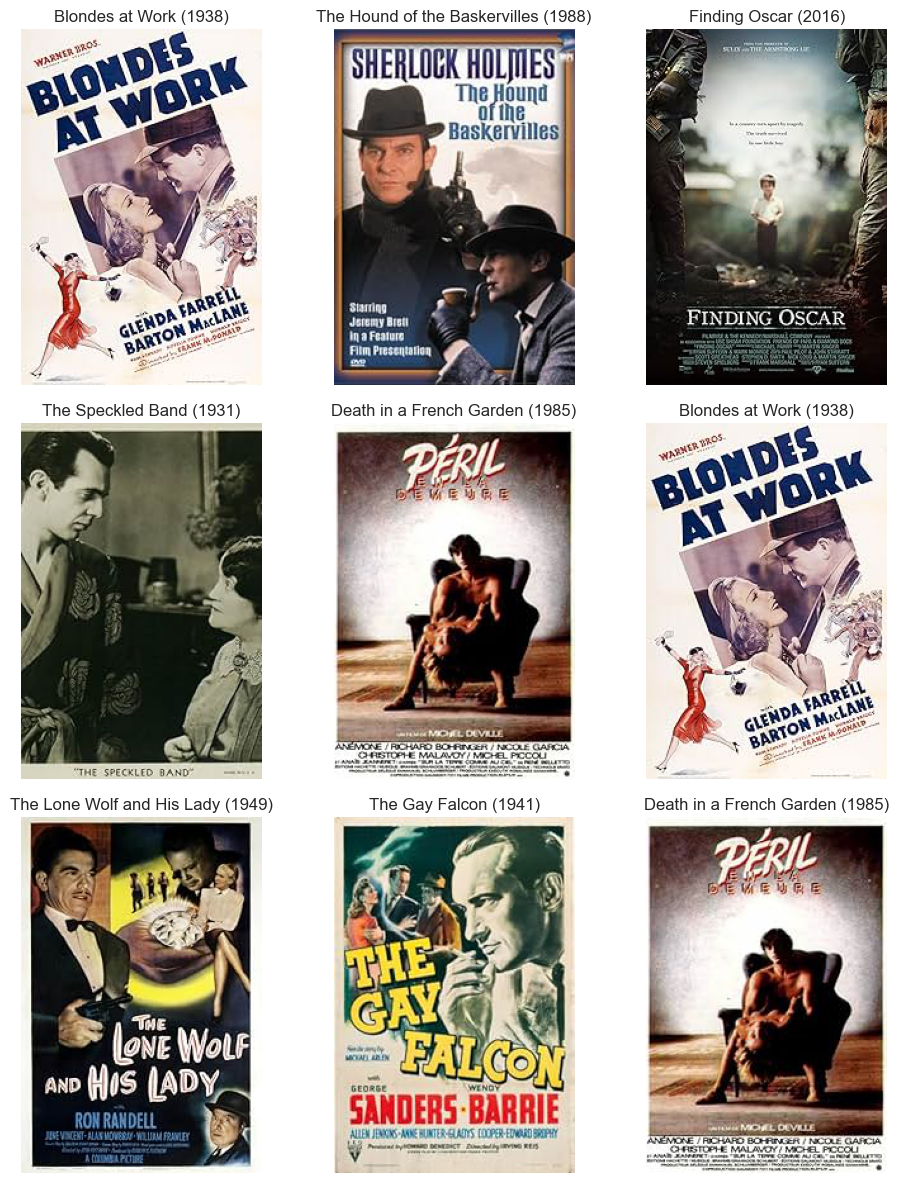

In [40]:
links = pd.read_csv('ml-latest/links.csv')
plt.figure(figsize=(10, 12))
i = 1

for mid in top_20:
    imdb_id = str(links[links['movieId'] == mid]['imdbId'].values[0])
    suggested_movie = movies[movies.movieId == mid]['title'].values[0]
    # condition to match id
    zero_prefix = 0
    if len(imdb_id) < 7:
        zero_prefix = 7 - len(imdb_id)
    imdb_id = 'tt' + zero_prefix * '0' + imdb_id
    print("Imbd Id:", imdb_id, "Movie:", suggested_movie)
    plt.subplot(3, 3, i)
    # plot image
    plt.imshow(get_image(imdb_id))
    plt.axis('off')
    plt.title(suggested_movie)
    # break if 9 movies shown
    if i == 9:
        break
    i += 1

del(links)
plt.tight_layout()
plt.show()

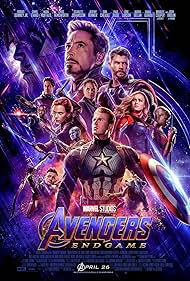

In [26]:
cur_img, img_bytes = get_image("tt4154796")
cur_img

In [50]:
import base64

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import base64
from io import BytesIO

class IMDBImageManager:
    """
    A class to fetch movie poster images from IMDb, encode them in Base64,
    and manage their storage in a pandas DataFrame.
    """
    def __init__(self, df: pd.DataFrame):
        """
        Initializes the IMDBImageManager with a pandas DataFrame.

        Args:
            df (pd.DataFrame): The DataFrame to store the image data. 
                              It must have columns named 'imdb_id' and 'base64_image'.
        """
        self.df = df
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
        }
        self.session = requests.Session()

    def _get_image_data(self, imdb_id: str) -> bytes | None:
        """
        A private helper method to get the raw image bytes from IMDb.

        Args:
            imdb_id (str): The IMDb ID of the movie (e.g., 'tt0111161').

        Returns:
            bytes | None: The raw image bytes if successful, otherwise None.
        """
        try:
            # Get the IMDb page content
            url = f"https://www.imdb.com/title/{imdb_id}"
            response = self.session.get(url, headers=self.headers, timeout=10)
            response.raise_for_status() # Raise an exception for bad status codes

            # Parse the HTML to find the image URL
            soup = BeautifulSoup(response.content, 'html.parser')
            img_tag = soup.find('img', attrs={'class': 'ipc-image'})
            
            if not img_tag:
                print(f"No image tag found for {imdb_id}")
                return None
            
            img_url = img_tag.get('src')
            if not img_url:
                print(f"No image source URL found for {imdb_id}")
                return None

            # Get the image content
            image_response = self.session.get(img_url, headers=self.headers, timeout=10)
            image_response.raise_for_status()
            
            return image_response.content
        
        except requests.exceptions.RequestException as e:
            print(f"Request error occurred for {imdb_id}: {e}")
            return None
        except Exception as e:
            print(f"Error occurred while processing {imdb_id}: {e}")
            return None

    def process_and_store_image(self, imdb_id: str):
        """
        Processes and stores the image for a given IMDb ID in the DataFrame.

        Args:
            imdb_id (str): The IMDb ID of the movie.
        """
        # Step 1: Check if the IMDb ID is already in the DataFrame
        if imdb_id in self.df['imdb_id'].values:
            print(f"IMDb ID '{imdb_id}' already exists in the DataFrame. Skipping download.")
            return

        # Step 2: Get the raw image data
        image_bytes = self._get_image_data(imdb_id)
        if not image_bytes:
            print(f"Could not get image data for '{imdb_id}'.")
            return

        # Step 3: Encode the image data to Base64
        base64_encoded_string = base64.b64encode(image_bytes).decode('utf-8')
        
        # Step 4: Add the new data to the DataFrame
        new_row = pd.DataFrame([{'imdb_id': imdb_id, 'base64_image': base64_encoded_string}])
        self.df = pd.concat([self.df, new_row], ignore_index=True)
        print(f"Successfully processed and stored image for '{imdb_id}'.")

if __name__ == "__main__":
    # Example usage:
    
    # 1. Create an initial DataFrame to store the data
    columns = ['imdb_id', 'base64_image']
    df = pd.DataFrame(columns=columns)
    
    # 2. Instantiate the manager with the DataFrame
    image_manager = IMDBImageManager(df)
    
    # 3. List of IMDb IDs to process
    imdb_ids_to_process = [
        'tt0111161', # The Shawshank Redemption
        'tt0068646', # The Godfather
        'tt0468569', # The Dark Knight
        'tt0111161'  # Intentionally a duplicate to demonstrate the check
    ]
    
    for imdb_id in imdb_ids_to_process:
        image_manager.process_and_store_image(imdb_id)
        
    # 4. Print the final DataFrame
    print("\n--- Final DataFrame ---")
    print(image_manager.df)
    
    # To view the image, you can write the base64 string to an HTML file or a local file:
    # with open("image_preview.html", "w") as f:
    #     f.write(f'<img src="data:image/jpeg;base64,{image_manager.df.iloc[0]["base64_image"]}" />')


In [32]:
links = pd.read_csv("../datasets/ml-latest/links.csv")
links.head()

,movieId,imdbId,tmdbId,base64_image
0,1,114709,862.0,NaN
1,2,113497,8844.0,NaN
2,3,113228,15602.0,NaN
3,4,114885,31357.0,NaN
4,5,113041,11862.0,NaN


In [28]:
links['base64_image'] = np.nan
links.head()

,movieId,imdbId,tmdbId,base64_image
0,1,114709,862.0,NaN
1,2,113497,8844.0,NaN
2,3,113228,15602.0,NaN
3,4,114885,31357.0,NaN
4,5,113041,11862.0,NaN


In [31]:
links = links.drop(columns=['Unnamed: 0'])
links.to_csv("../datasets/ml-latest/links.csv", index=False)